# [딥러닝 기본] RNN과 CNN을 이용한 텍스트 분류

## 13-02 LSTM을 이용한 네이버 영화 리뷰 분류
- 네이버 영화 리뷰에 대한 감성 분류를 수행하는 모델 만들기

In [2]:
import pickle                                           # 파이썬 객체를 파일로 저장/불러오기 위한 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request                                   # 인터넷에서 데이터 다운로드를 위한 모듈
from konlpy.tag import Mecab                            # 한국어 형태소 분석기
from tqdm import tqdm                                   # 반복문 진행 상황 표시
from sklearn.model_selection import train_test_split
from collections import Counter                         # 데이터 빈도 계산을 위한 모듈

##### 1. 데이터 로드하기

In [49]:
# 링크로부터 훈련 데이터, 테스트 데이터 다운로드 
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
    filename="/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/ratings_train.txt"
)

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
    filename="/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/ratings_test.txt"
)

('/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/ratings_test.txt',
 <http.client.HTTPMessage at 0x15222a0d0>)

In [3]:
# 데이터 불러오기
train_data = pd.read_table('/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/ratings_train.txt')
test_data = pd.read_table('/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/ratings_test.txt')

In [4]:
print('훈련용 리뷰 개수 :', len(train_data))

훈련용 리뷰 개수 : 150000


In [5]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


id는 감성 분류를 수행하는 데 필요하지 않으므로 제거   
모델은 document와 해당 리뷰가 긍정(1)인지 부정(0)인지를 나타내는 lablel 두 개의 열을 학습하는 모델이어야 함

In [6]:
print('테스트용 리뷰 개수 :', len(test_data))

테스트용 리뷰 개수 : 50000


In [7]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


한국어와 다르게 영어는 띄어쓰기 하지 않으면 문장의 의미를 파악하기 어려움

##### 2. 데이터 정제하기

In [8]:
# document 열과 label의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

약 4000개의 중복 리뷰가 존재

In [9]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [10]:
print('중복을 제거한 총 리뷰 개수 :', len(train_data))

중복을 제거한 총 리뷰 개수 : 146183


<Axes: xlabel='label'>

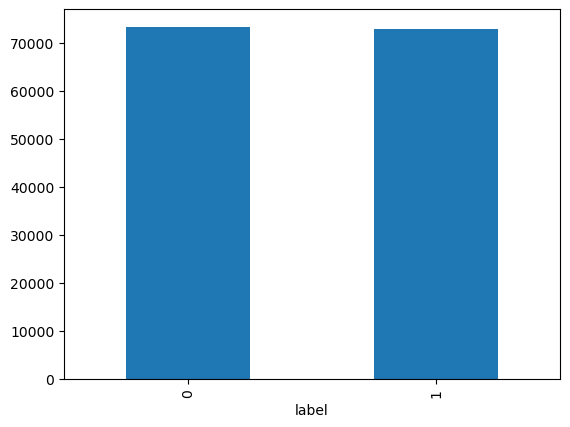

In [11]:
# train_data의 label 분포
train_data['label'].value_counts().plot(kind='bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name='count')) # 라벨 0,1 개수 근소하게 0(부정)이 더 많음

   label  count
0      0  73342
1      1  72841


In [13]:
# 리뷰의 null 값 확인
print(train_data.isnull().values.any())

True


In [14]:
print(train_data.isnull().sum()) # document 열에 null 값이 1개 존재

id          0
document    1
label       0
dtype: int64


In [15]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
# null 값 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any())     # Null 값이 존재하는지 확인

False


In [17]:
print(len(train_data))

146182


In [18]:
# 데이터 전처리 -> 정규 표현식을 이용해 특수문자 제거
## 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True) # regex=True: 해당 문자열을 정규표현식으로 인식하게 함
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


정규 표현식을 수행하니, 기존의 띄어쓰기는 유지되면서 온점, 쉼표, 특수문자 등이 제거된 것을 확인할 수 있음

In [19]:
# 기존에 한글이 없는 리뷰는 공백이 되므로, 공백만 있거나 빈 값을 가진 행 -> Null 값으로 변경 후 존재 확인
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # 공백 데이터를 empty 값으로 변경
train_data['document'].replace('', np.nan, inplace=True) # empty 값을 Null 값으로 변경
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/var/folders/ft/qy0hfkvd0rx250sfnxdbjr7r0000gn/T/ipykernel_14830/83353046.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True) # empty 값을 Null 값으로 변경


In [20]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [21]:
# 한글 리뷰만 남기는 정규 표현식 적용 후 Null 값 제거
train_data = train_data.dropna(how='any')
print(len(train_data))

145393


In [22]:
# test_data도 동일하게 전처리
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/var/folders/ft/qy0hfkvd0rx250sfnxdbjr7r0000gn/T/ipykernel_14830/2983246162.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


##### 3. 토큰화 

In [23]:
# 불용어 정의 및 제거
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [24]:
# Mecab 형태소 분석기를 이용해 토큰화 및 불용어 제거
mecab = Mecab('/opt/homebrew/lib/mecab/dic/mecab-ko-dic')

In [25]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 형태소 단위로 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [00:03<00:00, 37774.99it/s]


In [26]:
print(X_train[:3])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [27]:
# 테스트 데이터도 동일하게 토큰화 및 불용어 제거
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 형태소 단위로 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:01<00:00, 47170.30it/s]


##### 4. 학습 데이터, 검증 데이터, 테스트 데이터

In [30]:
# 학습데이터 중 20%를 검증 데이터로 분리
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [34]:
print('--------훈련 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100, 3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100, 3)} %') # count_nonzero(조건)는 True 개수를 세는 방식
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100, 3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------훈련 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762 %
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


##### 5. 단어 집합 만들기

In [35]:
word_list = []
for sent in X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list) # 단어와 빈도 수를 쌍으로 갖는 딕셔너리 생성(단어 집합 생성)
print('총 단어 수 :', len(word_counts))

총 단어 수 : 45296


In [40]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 45791
훈련 데이터에서의 단어 공감의 등장 횟수 : 756


In [41]:
# 등장 빈도수가 높은 순서대로 단어들을 정렬
vocab = sorted(word_counts, key=word_counts.get, reverse=True) # word_counts.get: 단어의 빈도 수 반환
print('등장 빈도수 상위 10개 단어 :', vocab[:10])

등장 빈도수 상위 10개 단어 : ['영화', '보', '있', '없', '좋', '나', '었', '만', '는데', '너무']


In [49]:
# 빈도수가 낮은 단어들을 자연어 처리에서 배제하고자 함
threshold = 3
total_cnt = len(word_counts)          # 단어의 수
rare_cnt = 0                         # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                        # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                         # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도수가 %s번 이하인 희귀 단어의 수 : %s'%(threshold - 1, rare_cnt)) # 첫 번째 %s ← threshold - 1 두 번째 %s ← rare_cnt
print('단어 집합에서의 희귀 단어의 비율:', round((rare_cnt / total_cnt) * 100, 3))
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', round((rare_freq / total_freq) * 100,3))

단어 집합(vocabulary)의 크기 : 45296
등장 빈도수가 2번 이하인 희귀 단어의 수 : 26104
단어 집합에서의 희귀 단어의 비율: 57.63
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 2.277


등장 빈도가 threshold 값인 3회 미만인 단어들은 단어 집합에서 절반 이상을 차지하지만,   
실제로 훈련 데이터에서 등장 빈도로 차지하는 비율은 2.27%밖에 되지 않으므로 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않은 듯 하다.

In [53]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 19192


In [54]:
# 패딩 토큰과 모르는 단어에 대응하기 위함 -> <PAD> : 0, <UNK> : 1, 이러한 단어들을 스페셜 토큰이라 함
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [60]:
print('단어 와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])

단어 와 맵핑되는 정수 : 0
단어 와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


In [55]:
for index, word in enumerate(vocab):
    word_to_index[word] = index + 2 # 0,1번은 이미 스페셜 토큰으로 사용했으므로 2부터 인덱스 부여

In [56]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 19194


##### 6. 정수 인코딩

In [61]:
# 현재 등장 빈도가 2회 이하인 단어들은 단어 집합에서 제거하였으므로 정수 인코딩 과정에서 <UNK> 로 매핑
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []                                     # 전체 데이터에 대한 정수 인코딩 결과를 담을 리스트
  for sent in tokenized_X_data:                           # sent는 한 문장
    index_sequences = []                                  # index_sequences는 한 문장에 대한 정수 인코딩 결과를 담을 리스트
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [62]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [63]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
    print(sent)

[924, 1866, 128, 7, 80, 48, 34]
[2415, 3138, 4, 2095, 422, 87, 5768, 19, 307]


In [64]:
# 단어가 key, 정수를 value로 가지는 단어집합인 word_to_index의 키, 정수를 뒤집어 index_to_word 만드는 작업
# 그리고 index_to_word를 이용하여 정수 인코딩 결과를 다시 텍스트로 변환 -> 이를 "디코딩"
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [65]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플:', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플: ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']


기존의 샘플과 복원된 샘플이 동일함을 확인할 수 있음

##### 7. 패딩

리뷰의 최대 길이 : 74
리뷰의 평균 길이 : 12.297


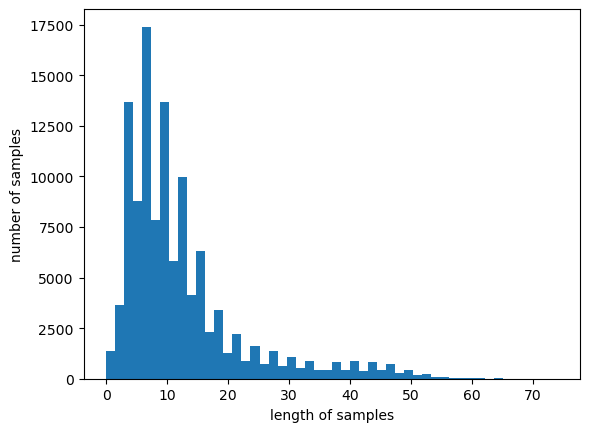

In [70]:
print('리뷰의 최대 길이 :', max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :', round(sum(map(len, encoded_X_train))/len(encoded_X_train),3)) # 각 원소에 len을 적용해 길이를 구하고, 평균 길이 계산
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있음

In [72]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [75]:
max_len = 30
below_threshold_len(max_len, X_train) 

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.49703389101914


전체 훈련 데이터 중 약 92%의 리뷰가 30이하의 길이를 가짐

In [77]:
# 모든 샘플의 길이를 30으로 맞추는 함수
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

In [78]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


In [80]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [ 924 1866  128    7   80   48   34    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


### 2. LSTM을 이용한 네이버 영화 리뷰 분류 모델

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [83]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [84]:
# 레이블 데이터를 텐서 타입으로 변환
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

In [86]:
print(train_label_tensor[:5])

tensor([0, 1, 1, 1, 1])


In [96]:
# LSTM 모델 설계
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [88]:
# 훈련 데이터 샘플 개수 116314에 대해 116314 // 32 = 3635개의 데이터 묶음 생김, 32개씩 묶인

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [89]:
total_batch = len(train_dataloader)
print('총 배치의 수 :', total_batch)

총 배치의 수 : 3635


In [90]:
# 모델 객체 선언, 하이퍼파라미터 설정
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10 # 3,636 batches × 10 epochs = 36,360 steps

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 3. 평가코드 작성

In [92]:
def calculate_accuracy(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [93]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

### 4. 학습

In [95]:
# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:

        # batch_X.shape == (batch_size, max_len)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/10:
Train Loss: 0.4276, Train Accuracy: 0.8081
Validation Loss: 0.4354, Validation Accuracy: 0.8020
Validation loss improved from inf to 0.4354. 체크포인트를 저장합니다.
Epoch 2/10:
Train Loss: 0.4022, Train Accuracy: 0.8228
Validation Loss: 0.4295, Validation Accuracy: 0.8050
Validation loss improved from 0.4354 to 0.4295. 체크포인트를 저장합니다.
Epoch 3/10:
Train Loss: 0.3966, Train Accuracy: 0.8263
Validation Loss: 0.4338, Validation Accuracy: 0.8017
Epoch 4/10:
Train Loss: 0.3893, Train Accuracy: 0.8294
Validation Loss: 0.4307, Validation Accuracy: 0.8075
Epoch 5/10:
Train Loss: 0.3794, Train Accuracy: 0.8347
Validation Loss: 0.4367, Validation Accuracy: 0.8042
Epoch 6/10:
Train Loss: 0.3789, Train Accuracy: 0.8350
Validation Loss: 0.4241, Validation Accuracy: 0.8097
Validation loss improved from 0.4295 to 0.4241. 체크포인트를 저장합니다.
Epoch 7/10:
Train Loss: 0.3705, Train Accuracy: 0.8383
Validation Loss: 0.4240, Validation Accuracy: 0.8121
Validation loss improved from 0.4241 to 0.4240. 체크포인트를 저장합니다.

### 5. 모델 로드 및 평가

In [97]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.4218
Best model validation accuracy: 0.8143


검증 데이터에 대한 정확도는 81.43%

In [98]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.4279
Best model test accuracy: 0.8109


테스트 데이터에 대한 정확도는 81.09%

### 6. 모델 테스트

In [99]:
index_to_tag = {0 : '부정', 1 : '긍정'}

In [100]:
def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = mecab.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [101]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"

predict(test_input, model, word_to_index, index_to_tag)

'긍정'

In [102]:
test_input = "이딴게 영화냐 ㅉㅉ"

predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [103]:
test_input = "감독 뭐하는 놈이냐?"

predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [104]:
test_input = "와 개쩐다 정말 세계관 최강자들의 영화다"

predict(test_input, model, word_to_index, index_to_tag)

'긍정'